
# Analysis Notebook

This notebook can be used to produce graphs and analyses for the data produced. It defaults to using the latest results, but that can be specified. 
*** 

## 0. Setup
This section imports all files and sets up the notebook.

In [149]:
# Import all pacakges
%matplotlib widget
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import src.utils as utils

In [150]:
# Choose which results to use
file_to_use = "" # If this is empty, the last file in the folder will be used
last_file = sorted(os.listdir('results/'))[-1]

if file_to_use == "":
    file_to_use = last_file
    
print("Using file: " + file_to_use)

Using file: 2023-06-09_16-01-44


In [151]:
# Import the .csvs and create dataframes

average_satisfaction_score_by_bidding_type = pd.read_csv(
    'results/' + file_to_use + '/average_satisfaction_score_by_bidding_type.csv')

average_throughput_per_intersection = pd.read_csv(
    'results/' + file_to_use + '/average_throughput_per_intersection.csv')


***

## 1. Satisfaction per Bidding Type

In [157]:
def plot_satisfaction_scores_by_bidding_type(data, with_std=False, epochs_range=[]):
    """Creates a graph of the average satisfaction score per epoch, optionally with error bars, averaged over all simulations,
        for each bidding type, represented by a different color.
    Args:
        data (pd.DataFrame): The dataframe containing the data to plot
        with_std (bool): Whether to include the standard deviation in the plot
    """
    # Get the columns with the satisfaction scores
    satisfaction_score_columns = [
        col for col in data.columns if 'bidding' in col]
    epochs = data['# Epoch']

    # Create a figure, with epochs on the x axies and satisfaction scores on the y axis
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average satisfaction score')

    # For each bidding type, plot the average satisfaction score per epoch
    for col in satisfaction_score_columns:
        if with_std:
            ax.errorbar(epochs, data[col], data[col + ' SD'], label=col)
        else:
            ax.plot(epochs, data[col], label=col, marker='o', linestyle='None')
    ax.legend()

    # Set the range of the x axis
    if len(epochs_range) > 0:
        ax.set_xlim(epochs_range[0], epochs_range[1])
        
    plt.show()
    plt.clf()


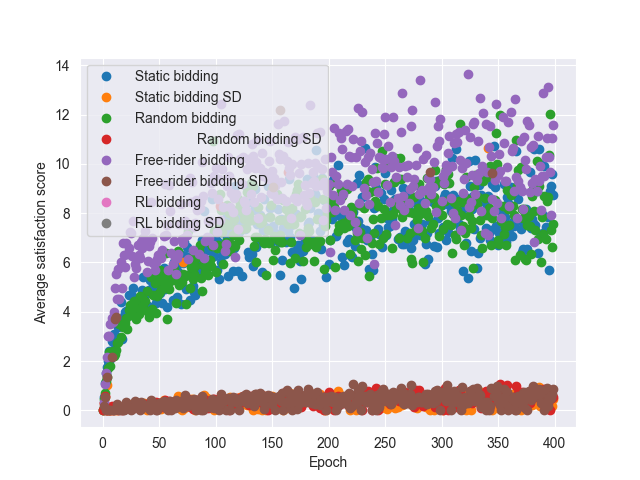

In [158]:
plot_satisfaction_scores_by_bidding_type(average_satisfaction_score_by_bidding_type, epochs_range=[])


***

## 2. Heatmap of Throughput per Intersection

In [154]:
def plot_throughput_heatmap_average(data):
    # The table contains the average throughput per intersection, with tables and rows as coordinates
    ax = sns.heatmap(data, annot=True)
    ax.set(xlabel='X coordinate', ylabel='Y coordinate',
        title='Average throughput per intersection')
    plt.show()
    plt.clf()
    

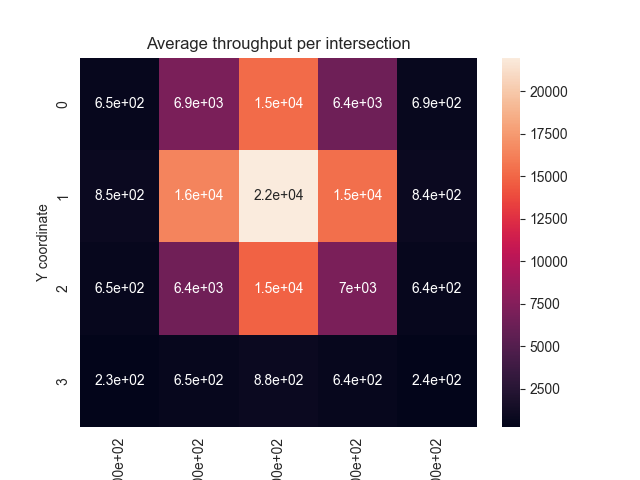

In [155]:
plot_throughput_heatmap_average(average_throughput_per_intersection)